Sobre a tarefa

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

Baixe os dados aqui (veja descrição dos dados mais abaixo).
Considere o pipeline mostrado nesse link (Links para um site externo)Links para um site externo para construir seus modelos de regressão. Isso implica, dentre outras coisas:
1-Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.
2-Construir modelos de regressão com (ridge e lasso) e sem regularização.
3-Considerar também modelos de regressão não paramétrica como K-NN.
4-Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests).
5-Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados.
6-Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema.
Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.
Dica: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados.
Responder:
Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.
A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f475b679690>,
      dtype=object)

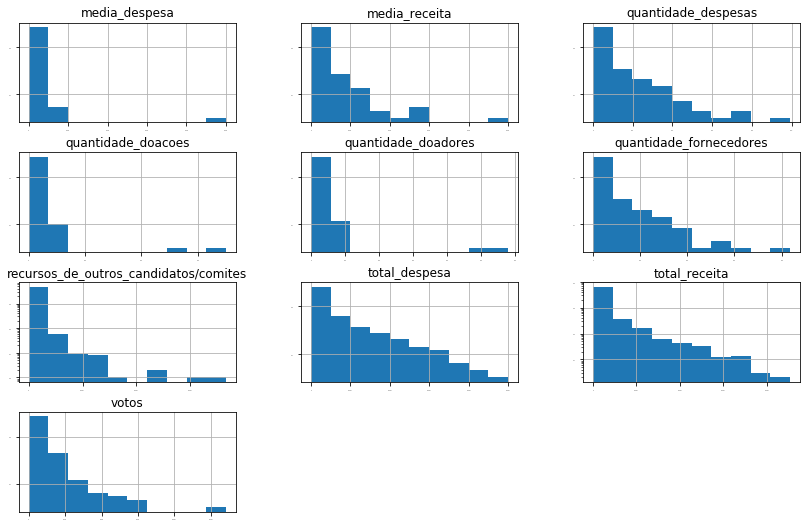

In [127]:
# Dados referentes as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010.
points = pd.read_csv("../data/eleicoes_2006_a_2010.csv")

matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)

#histograma das variáveis numéricas
dist_feats = pd.DataFrame({ "quantidade_doacoes":points["quantidade_doacoes"],
                            "quantidade_doadores":points["quantidade_doadores"],
                            "total_receita":points["total_receita"],
                            "media_receita":points["media_receita"],
                            "recursos_de_outros_candidatos/comites":points["recursos_de_outros_candidatos/comites"],
                            "quantidade_despesas":points["quantidade_despesas"],
                            "quantidade_fornecedores":points["quantidade_fornecedores"],
                            "total_despesa":points["total_despesa"],
                            "media_despesa":points["media_despesa"],
                            "votos":points["votos"]
                          })

dist_feats.hist(log=True, xlabelsize=0, ylabelsize=0)                

Todos os atributos numéricos possuem viés para direita, neste caso é preciso normalizar-los. Atributos irrelevantes como `sequencial_candidato` e `nome` podem ser removidos. Valores faltantes foram substituídos pela média do respectivo atributo. Os dados de treino e validação foram divididos de acordo com o ano, 2006 treino e 2010 validação.

In [130]:
#removendo variáveis irrelevantes
#points = points.drop(columns=['sequencial_candidato', 'nome'])

#selecionando atributos numéricos
numeric_feats = points.dtypes[points.dtypes != "object"].index

#calculando skew
# skewed_feats = points[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
# skewed_feats = skewed_feats[skewed_feats > 0.75]
# skewed_feats = skewed_feats.index

#filling NA's with the mean of the column:
points = points.fillna(points.mean())

#normalizando atributos numéricos exceto ano
points[numeric_feats[1 :]] = np.log1p(points[numeric_feats[1:]])

#particionando os dados
train = points.loc[:,:'ocupacao'].loc[points['ano'] == 2010]
y_train = points.loc[:,'votos':].loc[points['ano'] == 2010]
validation = points.loc[:,:'ocupacao'].loc[points['ano'] == 2006]
y_validation = points.loc[:,'votos':].loc[points['ano'] == 2006]

from sklearn.model_selection import train_test_split
entrada = points.loc[:,:'ocupacao']
saida = points.loc[:,'votos':]
x_treino, x_teste, y_treino, y_teste = train_test_split(entrada, saida)

x_treino = pd.get_dummies(x_treino)

#convertendo variáveis categóricas em dummy
train = pd.get_dummies(train)
validation = pd.get_dummies(validation)

Função para calcular o rmse da validação cruzada

In [123]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_treino, y_treino, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

### Regressão Linear Múltipla

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg_linear = LinearRegression()
reg_linear.fit(train, y_train)
mean_squared_error(y_train, reg_linear.predict(train))

0.7726126366540552

### Ridge

Text(0,0.5,'rmse')

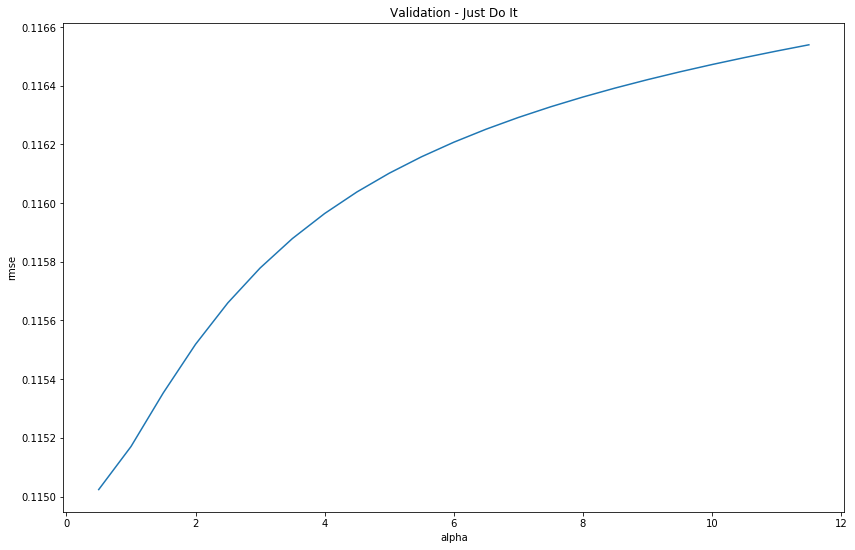

In [132]:
from sklearn.linear_model import Ridge
alphas_ridge = np.arange(0.5,12,0.5).tolist()
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas_ridge]
cv_ridge = pd.Series(cv_ridge, index = alphas_ridge)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

### Lasso

Text(0,0.5,'rmse')

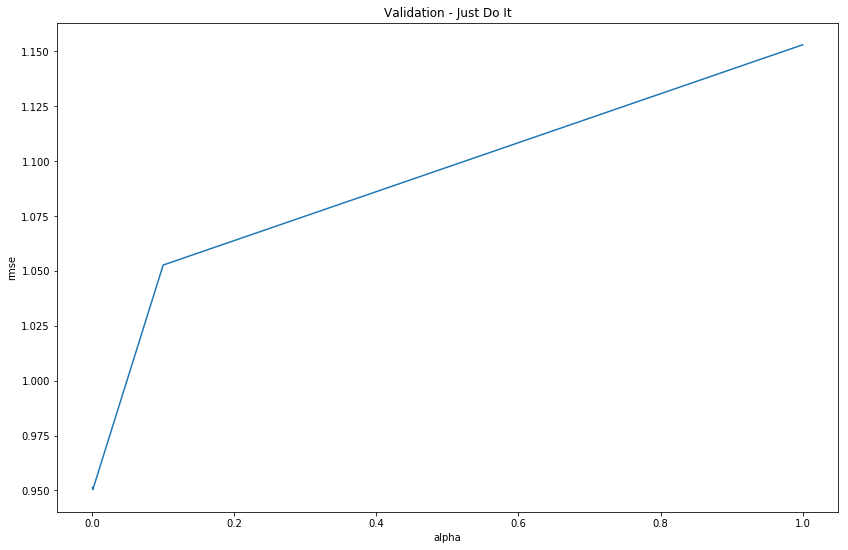

In [74]:
from sklearn.linear_model import Lasso
alphas_lasso = [1, 0.1, 0.001, 0.0005]

cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas_lasso]

cv_lasso = pd.Series(cv_lasso, index = alphas_lasso)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [22]:
from sklearn.svm import SVR
model_svr = SVR()
model_svr.fit(train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [111]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(train, y_train)

ValueError: Unknown label type: 'continuous'

In [112]:
y_train.shape

(3388, 1)